Using Python’s chardet library for guessing csv file encodings

In [5]:
%pip install chardet

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\sayan\appdata\local\programs\python\python312\lib\site-packages\entfa-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import chardet

# Read a portion or the entire file in binary mode
with open('AdventureWorks_Customers.csv', 'rb') as f:
    raw_data = f.read()

# Detect the encoding
result = chardet.detect(raw_data)
print(result)


{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [12]:
# %% [markdown]
# # Sales & Revenue Analysis ETL Notebook (No Separate Date Dimension)
#
# **Overview:**
# 1. Read CSV data for customers, products, and sales (2015–2017).
# 2. Clean and transform the data (including numeric conversions and date handling).
# 3. Create two dimension tables (customer and product).
# 4. Create one fact table (fact_sales) that includes OrderDate, StockDate, and other measures.
# 5. Load the results into MySQL, printing how many rows get dropped in each step.

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import pymysql
from dateutil import parser

# %% [markdown]
# ## 1. File Paths & Reading CSV
# Use `encoding="ISO-8859-1"` (or "latin1") if files aren't UTF-8 encoded.
# Use raw string literals (r"file\path") to avoid escape-sequence warnings on Windows.

customers_file = r"AdventureWorks_Customers.csv"
products_file = r"AdventureWorks_Products.csv"
sales_2015_file = r"AW Sales\AdventureWorks_Sales_2015.csv"
sales_2016_file = r"AW Sales\AdventureWorks_Sales_2016.csv"
sales_2017_file = r"AW Sales\AdventureWorks_Sales_2017.csv"

# Read CSV data
customers_df = pd.read_csv(customers_file, encoding="ISO-8859-1")
products_df = pd.read_csv(products_file, encoding="ISO-8859-1")
sales_2015_df = pd.read_csv(sales_2015_file, encoding="ISO-8859-1")
sales_2016_df = pd.read_csv(sales_2016_file, encoding="ISO-8859-1")
sales_2017_df = pd.read_csv(sales_2017_file, encoding="ISO-8859-1")

# %% [markdown]
# ## 2. Clean & Transform Customers
# - Parse BirthDate with multiple formats (slash, dash).
# - Clean AnnualIncome by removing '$', commas, etc.
# - Print how many rows we drop after cleaning.

def parse_birthdate(date_str):
    """Try to parse date in both slash and dash formats using dateutil."""
    try:
        return parser.parse(date_str)
    except:
        return pd.NaT

# Convert BirthDate
customers_df['BirthDate'] = customers_df['BirthDate'].apply(parse_birthdate)

# Clean AnnualIncome: remove '$', commas, spaces, then convert to numeric
customers_df['AnnualIncome'] = (
    customers_df['AnnualIncome']
    .replace({r'\$': '', ',': ''}, regex=True)
    .str.strip()
)
customers_df['AnnualIncome'] = pd.to_numeric(customers_df['AnnualIncome'], errors='coerce')

# Check uniqueness of CustomerKey
print("CustomerKey unique:", customers_df['CustomerKey'].is_unique)

# Count rows before dropping
before_drop = len(customers_df)
customers_df.dropna(subset=['CustomerKey', 'BirthDate', 'AnnualIncome'], inplace=True)
after_drop = len(customers_df)
print(f"Dropped {before_drop - after_drop} rows from customers_df due to missing CustomerKey/BirthDate/AnnualIncome.")

# %% [markdown]
# ## 3. Clean & Transform Products
# - Convert letter-based sizes (S, M, L, XL) to numeric (44, 48, 52, 62).
# - Ensure ProductPrice is numeric.
# - Print how many rows we drop.

size_mapping = {'S': 44, 'M': 48, 'L': 52, 'XL': 62}

def transform_size(x):
    """Convert product size to numeric if possible."""
    if isinstance(x, str):
        x = x.strip()
        if x in size_mapping:
            return size_mapping[x]
        else:
            try:
                return int(x)
            except ValueError:
                return np.nan
    return x

products_df['ProductSize'] = products_df['ProductSize'].apply(transform_size)
products_df['ProductSize'] = pd.to_numeric(products_df['ProductSize'], errors='coerce')

print("ProductKey unique:", products_df['ProductKey'].is_unique)

before_drop = len(products_df)
products_df.dropna(subset=['ProductKey', 'ProductPrice'], inplace=True)
after_drop = len(products_df)
print(f"Dropped {before_drop - after_drop} rows from products_df due to missing ProductKey/ProductPrice.")

# %% [markdown]
# ## 4. Combine & Clean Sales Data
# - Concatenate 2015, 2016, 2017 sales.
# - Convert OrderDate & StockDate to datetime (coerce invalid).
# - Create a composite key (OrderNumber + OrderLineItem).
# - Print how many rows we drop.

sales_df = pd.concat([sales_2015_df, sales_2016_df, sales_2017_df], ignore_index=True)

sales_df['OrderDate'] = pd.to_datetime(sales_df['OrderDate'], errors='coerce')
sales_df['StockDate'] = pd.to_datetime(sales_df['StockDate'], errors='coerce')

sales_df['CompositeKey'] = (
    sales_df['OrderNumber'].astype(str) + "_" +
    sales_df['OrderLineItem'].astype(str)
)
print("Composite Sales Key unique:", sales_df['CompositeKey'].is_unique)

before_drop = len(sales_df)
sales_df.dropna(subset=['OrderDate', 'ProductKey', 'CustomerKey', 'OrderQuantity'], inplace=True)
after_drop = len(sales_df)
print(f"Dropped {before_drop - after_drop} rows from sales_df due to missing OrderDate/ProductKey/CustomerKey/OrderQuantity.")

# %% [markdown]
# ## 5. Calculate Revenue
# Join sales with product price to get ProductPrice and compute `Revenue = OrderQuantity * ProductPrice`.

sales_df = sales_df.merge(
    products_df[['ProductKey', 'ProductPrice']],
    on='ProductKey',
    how='left'
)
sales_df['Revenue'] = sales_df['OrderQuantity'] * sales_df['ProductPrice']

# %% [markdown]
# ## 6. Build Dimensions

# ### 6.1 dim_customer
dim_customer = customers_df.drop_duplicates(subset=['CustomerKey']).copy()

# ### 6.2 dim_product
dim_product = products_df.drop_duplicates(subset=['ProductKey']).copy()

# %% [markdown]
# ## 7. Build the Fact Table (fact_sales)
# Fields:
# - CompositeKey (unique line item ID)
# - CustomerKey, ProductKey
# - OrderDate, StockDate
# - OrderQuantity, ProductPrice, Revenue

fact_sales = sales_df.merge(
    dim_customer[['CustomerKey']], on='CustomerKey', how='left'
).merge(
    dim_product[['ProductKey']], on='ProductKey', how='left'
)

fact_sales = fact_sales[[
    'CompositeKey',
    'CustomerKey',
    'ProductKey',
    'OrderDate',
    'StockDate',
    'OrderQuantity',
    'ProductPrice',
    'Revenue'
]]

# %% [markdown]
# ## 8. Load to MySQL
# Adjust credentials as needed.

username = 'root'
password = '12345'
host = 'localhost'
port = '3306'
database = 'case5'
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

dim_customer.to_sql('dim_customer', engine, index=False, if_exists='replace')
dim_product.to_sql('dim_product', engine, index=False, if_exists='replace')
fact_sales.to_sql('fact_sales', engine, index=False, if_exists='replace')

print("Data loaded to MySQL successfully!")


CustomerKey unique: True
Dropped 0 rows from customers_df due to missing CustomerKey/BirthDate/AnnualIncome.
ProductKey unique: True
Dropped 0 rows from products_df due to missing ProductKey/ProductPrice.
Composite Sales Key unique: True
Dropped 0 rows from sales_df due to missing OrderDate/ProductKey/CustomerKey/OrderQuantity.
Data loaded to MySQL successfully!


## Predictive Modeling

In [ ]:
%pip install prophet lifetimes

10:57:29 - cmdstanpy - INFO - Chain [1] start processing
10:57:29 - cmdstanpy - INFO - Chain [1] done processing


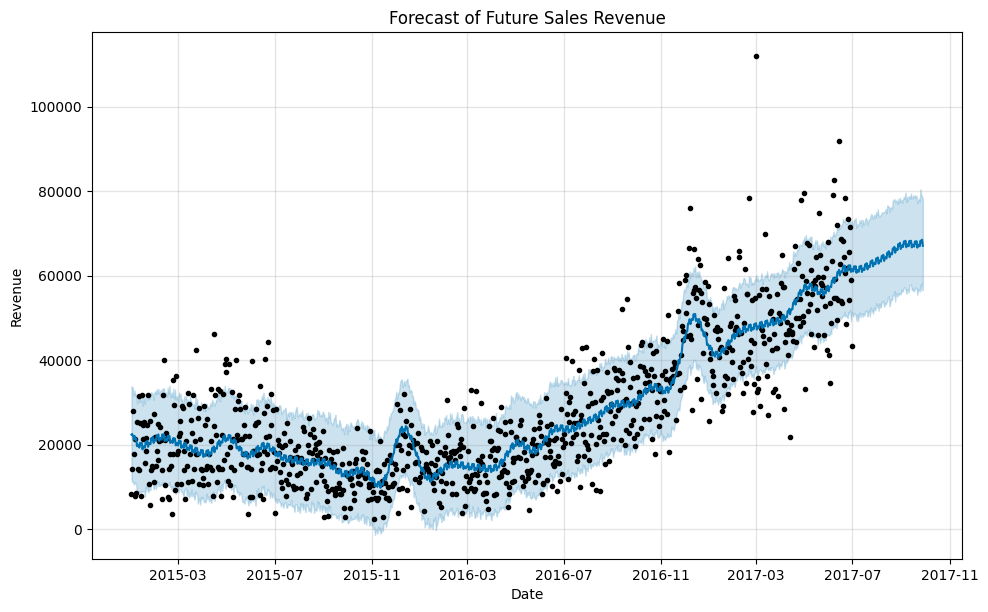

             predicted_purchases_90  expected_average_profit         CLV
CustomerKey                                                             
11000                      0.102820              1250.438714  452.751945
11001                      0.154021              1152.321324  625.015258
11002                      0.087224              1244.229811  382.296050
11003                      0.104205              1245.937232  457.305986
11004                      0.102425              1244.229811  448.740106


In [15]:
# %% [markdown]
# # Predictive Modeling: Forecast Future Sales Trends

import matplotlib.pyplot as plt
from prophet import Prophet  # pip install prophet

# Aggregate daily revenue from fact_sales
# (Assumes fact_sales has an 'OrderDate' column and 'Revenue' measure)
sales_trends = fact_sales.groupby('OrderDate')['Revenue'].sum().reset_index()
sales_trends.columns = ['ds', 'y']  # Prophet expects columns "ds" (date) and "y" (value)

# Create and fit the Prophet model
model = Prophet()
model.fit(sales_trends)

# Create a DataFrame for future dates (e.g., forecast for the next 90 days)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("Forecast of Future Sales Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

# %% [markdown]
# # Predictive Modeling: Customer Lifetime Value (CLV) Prediction

from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Ensure OrderDate is in datetime format (should already be true from ETL)
fact_sales['OrderDate'] = pd.to_datetime(fact_sales['OrderDate'])

# Define the observation period end date as the latest OrderDate in fact_sales
observation_end_date = fact_sales['OrderDate'].max()

# Create a summary of customer transactions:
# - frequency: number of repeat purchases (customers with only 1 purchase have frequency 0)
# - recency: time between first and last purchase (in days)
# - T: the age of the customer (in days) at the end of the observation period
# - monetary_value: average revenue per transaction
summary = summary_data_from_transaction_data(
    transactions=fact_sales,
    customer_id_col='CustomerKey',
    datetime_col='OrderDate',
    monetary_value_col='Revenue',
    observation_period_end=observation_end_date
)

# For the monetary value model, filter out customers with frequency 0
summary_filtered = summary[summary['frequency'] > 0]

# Fit the BG/NBD model to predict the number of future purchases
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary_filtered['frequency'], summary_filtered['recency'], summary_filtered['T'])

# Predict the expected number of purchases for each customer in the next 90 days
summary_filtered['predicted_purchases_90'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    90, summary_filtered['frequency'], summary_filtered['recency'], summary_filtered['T']
)

# Fit the Gamma-Gamma model for predicting the average monetary value per transaction
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(summary_filtered['frequency'], summary_filtered['monetary_value'])
summary_filtered['expected_average_profit'] = ggf.conditional_expected_average_profit(
    summary_filtered['frequency'], summary_filtered['monetary_value']
)

# Calculate Customer Lifetime Value (CLV) for each customer over a 12-month horizon.
# - time=12 means 12 months, and freq='D' indicates that T is measured in days.
# - discount_rate is set to 1% per period (adjust as needed).
summary_filtered['CLV'] = ggf.customer_lifetime_value(
    bgf,
    summary_filtered['frequency'],
    summary_filtered['recency'],
    summary_filtered['T'],
    summary_filtered['monetary_value'],
    time=12,         # time horizon in months
    freq='D',        # frequency: T is in days
    discount_rate=0.01
)

# Display a sample of the CLV predictions
print(summary_filtered[['predicted_purchases_90', 'expected_average_profit', 'CLV']].head())
